# Demo - Siren

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])
exp = here(relative_project_path=root.joinpath("experiments/expv2"))


# append to path
sys.path.append(str(root))
sys.path.append(str(exp))

In [2]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm as tqdm
import os, imageio
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

from skorch.callbacks import EarlyStopping, LRScheduler, WandbLogger

from inr4ssh._src.models.siren import Siren, SirenNet, Modulator, ModulatedSirenNet

import wandb

%load_ext autoreload
%autoreload 2

In [3]:
import config
import argparse


In [5]:
# initialize argparse
parser = argparse.ArgumentParser()

# add all experiment arguments
parser = config.add_logging_args(parser)
parser = config.add_data_dir_args(parser)
parser = config.add_data_preprocess_args(parser)
parser = config.add_feature_transform_args(parser)
parser = config.add_train_split_args(parser)
parser = config.add_dataloader_args(parser)
parser = config.add_model_args(parser)
parser = config.add_loss_args(parser)
parser = config.add_optimizer_args(parser)
parser = config.add_eval_data_args(parser)
parser = config.add_eval_metrics_args(parser)
parser = config.add_viz_data_args(parser)

# parse args
args = parser.parse_args([])

# modify args
args.train_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/train"
args.ref_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/ref"
args.test_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/test"
#
args.time_min = "2017-01-01"
args.time_max = "2017-02-01"
args.eval_time_min = "2017-01-01"
args.eval_time_max = "2017-02-01"
args.eval_dtime = "12_h"

# logger args
args.wandb_resume = True
args.wandb_mode = "online"
args.wandb_project = "inr4ssh"
args.wandb_entity = "ige"
args.wandb_id = None

In [6]:
args

Namespace(wandb_project='inr4ssh', wandb_entity='ige', wandb_log_dir='./', wandb_resume=True, wandb_mode='online', smoke_test=False, wandb_id=None, train_data_dir='/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/train', ref_data_dir='/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/ref', test_data_dir='/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/test', lon_min=285.0, lon_max=315.0, dlon=0.2, lat_min=23.0, lat_max=53.0, dlat=0.2, time_min='2017-01-01', time_max='2017-02-01', dtime='1_D', lon_buffer=1.0, lat_buffer=1.0, time_buffer=7.0, julian_time=True, abs_time_min='2005-01-01', abs_time_max='2022-01-01', feature_scaler='minmax', min_time_scale=-1.0, max_time_scale=1.0, spherical_radius=1.0, train_size=0.9, train_seed_split=666, train_seed_shuffle=321, train_split_method='random', train_split_time_freq=None, train_split_spatial='random', dl_train_shuffle=True, dl_pin_memory=False, dl_num_workers=0, batch_size=4096, batch_size_eval=10000, model='siren', encoder=None, h

In [7]:
wandb_run = wandb.init(
        config=args,
        mode=args.wandb_mode,
        project=args.wandb_project,
        entity=args.wandb_entity,
        dir=args.wandb_log_dir,
        resume=args.wandb_resume
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin


to extract a default argument if it is in the name space
`lr = getattr(args, "lr", 1e-4)`

In [8]:
from inr4ssh._src.datamodules.ssh_obs import SSHAltimetry

In [9]:
dm = SSHAltimetry(args)

In [10]:
dm = dm.setup()

2022-07-04 14:58:51.306 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:24 - Getting training data...
2022-07-04 14:58:51.306 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:57 - loading data...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 38.13it/s]
2022-07-04 14:58:51.883 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:60 - subsetting data...
2022-07-04 14:58:51.912 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:63 - getting feature scaler...
2022-07-04 14:58:51.913 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:66 - feature scaling...
2022-07-04 14:58:51.978 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:28 - Train/Va

In [11]:
dl_train = dm.train_dataloader()
dl_valid = dm.val_dataloader()
dl_predict = dm.predict_dataloader()

In [12]:
len(dm.ds_train), len(dm.ds_valid), len(dm.ds_predict)

(255185, 28354, 167076)

## Skorch Training

In [13]:
X_train, y_train = dm.ds_train[:]
X_valid, y_valid = dm.ds_valid[:]
X_test, = dm.ds_predict[:]
X_train = torch.cat([X_train, X_valid])
y_train = torch.cat([y_train, y_valid])

In [14]:
X_train.shape, X_test.shape

(torch.Size([283539, 4]), torch.Size([167076, 4]))

In [15]:
from inr4ssh._src.models.activations import get_activation

In [16]:
dim_in = X_train.shape[1]
dim_hidden = args.hidden_dim
dim_out = y_train.shape[1]
num_layers = args.n_hidden
w0 = args.siren_w0
w0_initial = args.siren_w0_initial
c = args.siren_c
final_activation = get_activation(args.final_activation)

In [17]:


siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
    final_activation=final_activation
)

In [25]:
if torch.has_mps:
    device = "mps"
elif torch.has_cuda:
    device = "cuda"
else:
    device = "cpu"
device = "cpu"


In [26]:

from torch.optim.lr_scheduler import CosineAnnealingLR

In [27]:
1e-2

0.01

In [28]:
# # learning rate scheduler
# lr_scheduler = LRScheduler(
#     policy="ReduceLROnPlateau",
#     monitor="valid_loss",
#     mode="min",
#     factor=0.1,
#     patience=5,
# )
# learning rate scheduler
args.num_epochs = 200
args.learning_rate = 1e-3
lr_scheduler = LRScheduler(
    policy=CosineAnnealingLR,
    T_max=args.num_epochs
)

# early stopping
estop_callback = EarlyStopping(
    monitor="valid_loss", 
    patience=30,
)

wandb_callback = WandbLogger(wandb_run, )

callbacks = [
    ("earlystopping", estop_callback),
    ("lrscheduler", lr_scheduler),
    ("wandb_logger", wandb_callback),
]

In [29]:
from skorch.dataset import ValidSplit

# train split percentage
train_split = ValidSplit(0.1, stratified=False)

In [30]:
from skorch import NeuralNetRegressor

skorch_net = NeuralNetRegressor(
    module=siren_net,
    max_epochs=args.num_epochs,
    lr=args.learning_rate,
    batch_size=args.batch_size,
    device=device,
    optimizer=torch.optim.Adam,
    train_split=train_split,
    callbacks=callbacks

)

In [31]:
skorch_net.fit(X_train, y_train)

  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.3719        0.0147  0.0010  9.8286
      2        0.0142        0.0144  0.0010  8.6888
      3        0.0136        0.0130  0.0010  8.5137
      4        0.0133        0.0137  0.0010  9.1775
      5        0.0130        0.0145  0.0010  8.8619
      6        0.0128        0.0142  0.0010  9.0822
      7        0.0127        0.0135  0.0010  8.9262
      8        0.0123        0.0136  0.0010  8.7704
      9        0.0121        0.0137  0.0010  8.9962
     10        0.0119        0.0133  0.0010  8.7336
     11        0.0117        0.0128  0.0010  8.8738
     12        0.0115        0.0118  0.0010  8.4845
     13        0.0114        0.0116  0.0010  9.6237
     14        0.0113        0.0112  0.0010  9.5671
     15        0.0111        0.0109  0.0010  8.6528
     16        0.0110        0.0106  0.0010  9.1720
     17        0.0108        0.0103  0.0010  9.1808
     18     

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SirenNet(
    (layers): ModuleList(
      (0): Siren(
        (activation): Sine()
      )
      (1): Siren(
        (activation): Sine()
      )
      (2): Siren(
        (activation): Sine()
      )
      (3): Siren(
        (activation): Sine()
      )
      (4): Siren(
        (activation): Sine()
      )
      (5): Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  ),
)

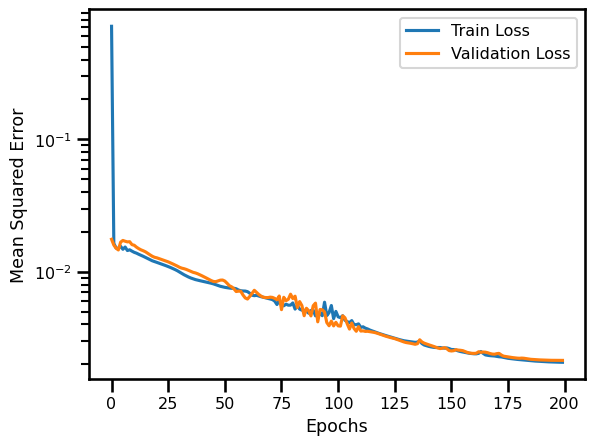

In [119]:
fig, ax = plt.subplots()

ax.plot(skorch_net.history[:, "train_loss"], label="Train Loss")
ax.plot(skorch_net.history[:, "valid_loss"], label="Validation Loss")

ax.set(yscale="log", xlabel="Epochs", ylabel="Mean Squared Error")

plt.legend()
plt.show()

In [33]:
%%time
import time

t0 = time.time()
predictions = skorch_net.predict(X_test)
t1 = time.time() - t0

wandb_run.log(
        {
            "time_predict": t1,
        }
    )

CPU times: user 4.17 s, sys: 793 ms, total: 4.96 s
Wall time: 2.56 s


In [121]:
from inr4ssh._src.data.ssh_obs import load_ssh_correction
from inr4ssh._src.postprocess.ssh_obs import postprocess
from inr4ssh._src.features.data_struct import df_2_xr

In [122]:
# convert to da
ds_oi = dm.X_pred_index
ds_oi["ssh"] = predictions
ds_oi = df_2_xr(ds_oi)

# open correction dataset
ds_correct = load_ssh_correction(args.ref_data_dir)


# correct predictions
ds_oi = postprocess(ds_oi, ds_correct)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWa

In [123]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 52, longitude: 51, time: 63)
Coordinates:
  * latitude   (latitude) float64 33.0 33.2 33.4 33.6 ... 42.6 42.8 43.0 43.2
  * longitude  (longitude) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-02-01
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 ... 167073 167074 167075
    ssh        (latitude, longitude, time) float64 0.7668 0.7664 ... -0.08425

In [124]:
import hvplot.xarray

In [125]:
ds_oi.ssh.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="viridis")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh)

In [126]:
from inr4ssh._src.operators.finite_diff import calculate_gradient, calculate_laplacian
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [127]:
ds_oi.ssh_grad.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="Spectral_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_grad)

In [128]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [129]:
ds_oi.ssh_lap.hvplot.image(
    x="longitude",
    y="latitude",
    # groupby='time',
    # rasterize=True, 
    width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (ssh_lap)

## PyTorch-Lightning Training

In [ ]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    
    # find indices 
    indx = np.where(
        (
            np.abs(ds_test_obs_summer.time.values - ds.time.values[tt]) <= dt
        )
    )[0]
    
    # subset data
    lat = ds_test_obs_summer.latitude.values[indx]
    lon = ds_test_obs_summer.longitude.values[indx]
    data = ds_test_obs_summer.sla_unfiltered.values[indx]
    
    vmin = ds_test_obs_summer.sla_unfiltered.min()
    vmax = ds_test_obs_summer.sla_unfiltered.max()
    
    # do scatter plot
    ax = fig.add_subplot(111, aspect='equal')
    
    pts = ax.scatter(
        lon, lat, c=data, 
        cmap="RdBu_r", 
        vmin=ds_test_obs_summer.sla_unfiltered.min(), 
        vmax=ds_test_obs_summer.sla_unfiltered.max()
    )
    ax.set_title("")
    ax.set_facecolor("0.5")
    ax.set_aspect(0.75)
    ax.set(
        xlim=[
            ds.longitude.values.min()-0.5,
            ds.longitude.values.max()+0.5
        ],
        ylim=[
            ds.latitude.values.min()-0.5,
            ds.latitude.values.max()+0.5,
        ]
    )
    plt.colorbar(pts)
    # plt.tight_layout()
    
    return None, None

In [ ]:
mov_custom = Movie(ds_summer.sla, custom_plotfunc)

In [ ]:
mov_custom.preview(9)

In [ ]:
mov_custom.save(
    "plots/movie_ssh_gulf_jja_test.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

In [ ]:
def make_customplotfunc(ds_obs):
    def f(ds, fig, tt, *args, **kwargs):

        # find indices 
        indx = np.where(
            (
                np.abs(ds_obs.time.values - ds.time.values[tt]) <= dt
            )
        )[0]

        # subset data
        lat = ds_obs.latitude.values[indx]
        lon = ds_obs.longitude.values[indx]
        data = ds_obs.sla_unfiltered.values[indx]

        vmin = ds_obs.sla_unfiltered.min()
        vmax = ds_obs.sla_unfiltered.max()

        # do scatter plot
        ax = fig.add_subplot(111, aspect='equal')

        pts = ax.scatter(
            lon, lat, c=data, 
            cmap="RdBu_r", 
            vmin=ds_obs.sla_unfiltered.min(), 
            vmax=ds_obs.sla_unfiltered.max()
        )
        ax.set_title(f"{ds.time.values[tt]:.10}")
        ax.set_facecolor("0.5")
        ax.set_aspect(0.75)
        ax.set(
            xlim=[
                ds.longitude.values.min()-0.5,
                ds.longitude.values.max()+0.5
            ],
            ylim=[
                ds.latitude.values.min()-0.5,
                ds.latitude.values.max()+0.5,
            ],
            xlabel="Longitudes [degrees_east]",
            ylabel="Latitudes [degrees_north]",
        )
        plt.colorbar(pts)
        plt.tight_layout()

        return None, None
    
    return f

In [ ]:
f_cust = make_customplotfunc(ds_test_obs_winter)

mov_custom = Movie(ds_winter.sla, f_cust)

In [ ]:
mov_custom.save(
    "plots/movie_ssh_gulf_djf_test.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

In [5]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm as tqdm
import os, imageio

from ml4ssh._src.models.siren import Siren, SirenNet, Modulator, ModulatedSirenNet
from ml4ssh._src.models.activations import Sine
from ml4ssh._src.data.images import load_fox
from ml4ssh._src.features import get_image_coordinates
from ml4ssh._src.datamodules.images import ImageFox, ImageCameraman
from torch.nn import ReLU
import pytorch_lightning as pl
from ml4ssh._src.models.image import ImageModel
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.utilities.argparse import add_argparse_args
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

In [6]:
img = load_fox()

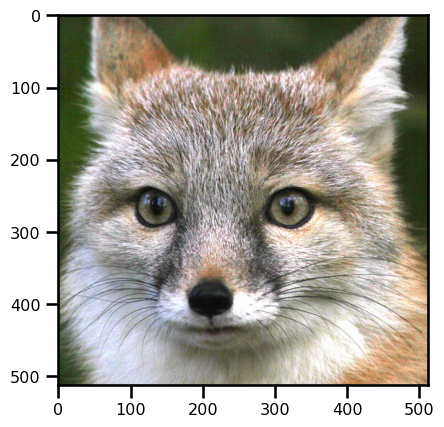

In [7]:
plt.figure()
plt.imshow(img)
plt.show()

### Data Module

In [43]:
# dm = ImageFox(batch_size=1024).setup()
dm = ImageCameraman(batch_size=4096).setup()

In [44]:
len(dm.ds_train)

131072

## Siren Net


### Sine Activation Layer

In [45]:
init = dm.ds_train[:32]
x_init, y_init = init
x_init.shape, y_init.shape

(torch.Size([32, 2]), torch.Size([32, 1]))

In [46]:
out = Sine()(x_init)

out.shape

torch.Size([32, 2])

In [47]:
# x_img = rearrange(out.numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [48]:
# plt.imshow(x_img)
# plt.show()

### Siren Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sin\left(\omega_0 \left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)\right)
$$

In [20]:
dim_in = x_init.shape[1]
dim_out = y_init.shape[1]
w0 = 1.0
c = 6.0

layer = Siren(
    dim_in=dim_in, dim_out=dim_out, 
    w0=w0, c=c, 
)

In [21]:
out = layer(x_init)

In [22]:
# x_img = rearrange(out.detach().numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [23]:
# plt.imshow(x_img)
# plt.show()

### Siren Network

In [24]:
dim_in = x_init.shape[1]
dim_hidden = 256
dim_out = y_init.shape[1]
num_layers = 3
w0 = 1.0
w0_initial = 30.0
c = 6.0

siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
)

In [25]:
out = siren_net(x_init)

In [26]:
# x_img = rearrange(out.detach().numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [27]:
siren_net

SirenNet(
  (layers): ModuleList(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Siren(
      (activation): Sine()
    )
  )
  (last_layer): Siren(
    (activation): Identity()
  )
)

## Experiment

In [28]:
import pytorch_lightning as pl
pl.seed_everything(123)

Global seed set to 123


123

#### Dataset



In [29]:
learning_rate = 1e-4
siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
)
dm = ImageCameraman(batch_size=4096).setup()

In [30]:
learn = ImageModel(siren_net, learning_rate=learning_rate)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [31]:
callbacks = [
    TQDMProgressBar(refresh_rate=100)
]

In [32]:
trainer = Trainer(
    min_epochs=1,
    max_epochs=3,
    accelerator="mps",
    enable_progress_bar=True,
    logger=None,
    callbacks=callbacks,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(learn, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.train_dataloader())

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /Users/eman/code_projects/ml4ssh/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type     | Params
-----------------------------------
0 | model | SirenNet | 132 K 
1 | loss  | MSELoss  | 0     
-----------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [35]:
trainer.test(learn, dataloaders=dm.test_dataloader())

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.08347434550523758    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08347434550523758}]

In [36]:
# t0 = time.time()
predictions = trainer.predict(learn, dataloaders=dm, return_predictions=True)
predictions = torch.cat(predictions)
# t1 = time.time() - t0

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 32it [00:00, ?it/s]

In [37]:
predictions.shape

torch.Size([262144, 1])

In [38]:
predictions.min(), predictions.max()

(tensor(-0.6253), tensor(1.9002))

In [39]:
from einops import rearrange

In [41]:
img_pred = dm.coordinates_2_image(predictions)

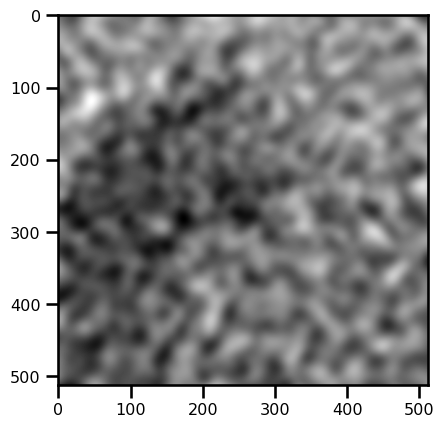

In [42]:
plt.figure()
plt.imshow(img_pred, cmap="gray")
plt.show()